In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import pandas as pd

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df_test = pd.read_csv('/content/fashion-mnist_test.csv')
df.head(5)
print(df.shape)
print(df_test.shape)
# df_cpu = df[:6000]
# df_cpu.head

(60000, 785)
(10000, 785)


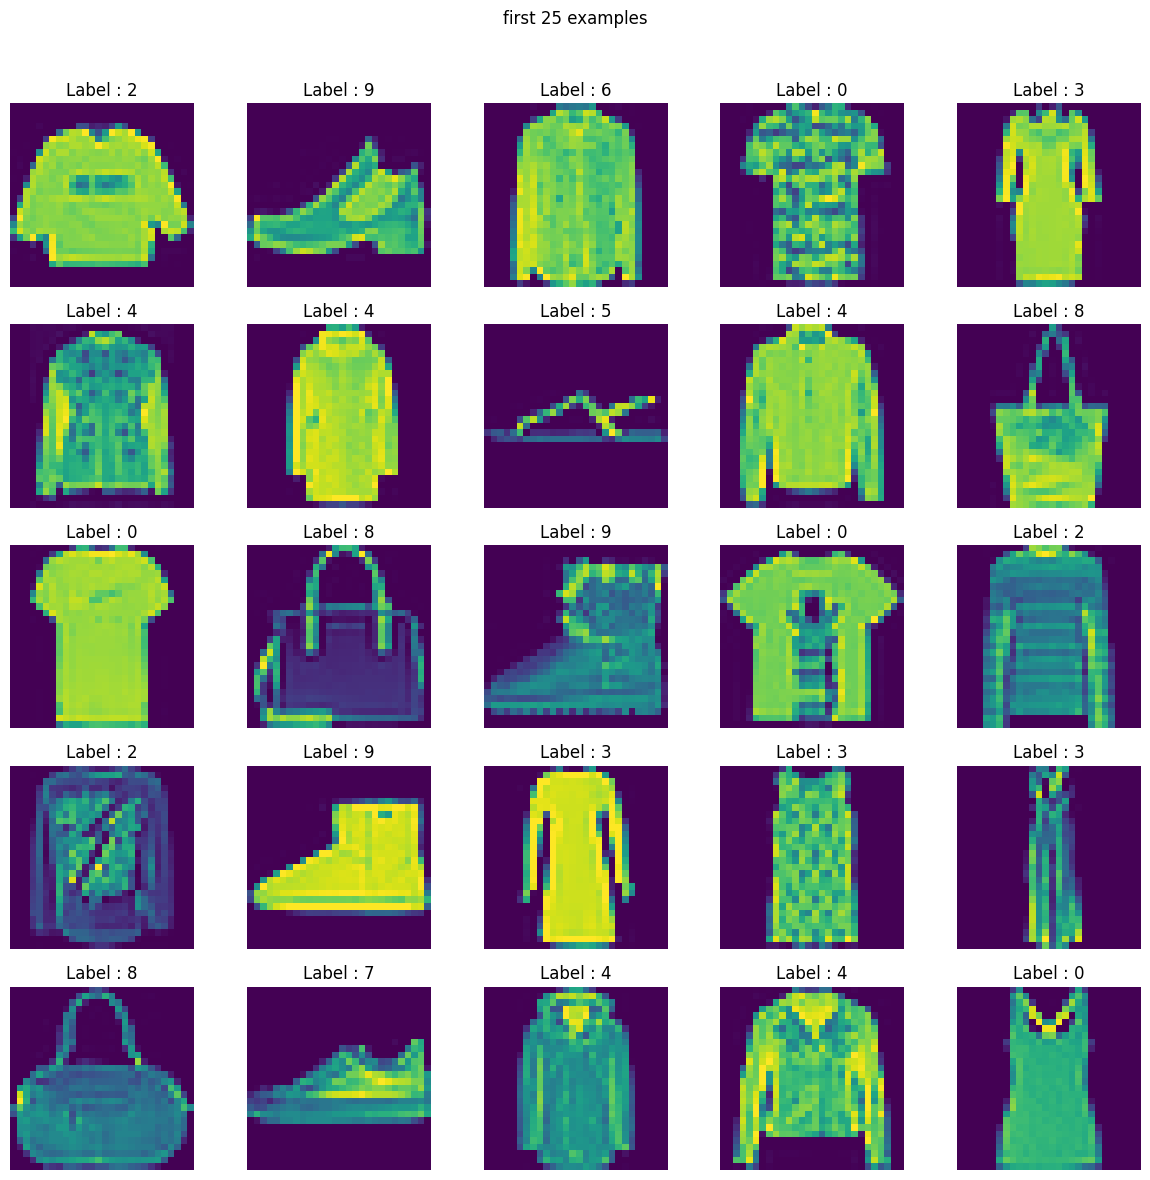

In [ ]:
fig, axes = plt.subplots(5, 5, figsize = (12,12))
fig.suptitle("first 25 examples")

for i,ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label : {df.iloc[i,0]}')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [ ]:
X_train = df.iloc[:,1:].values
Y_train = df.iloc[:,0].values
X_test = df_test.iloc[:,1:].values
Y_test = df_test.iloc[:,0].values

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(x, y ,test_size=0.2, random_state=123)


(60000, 784)
int64
(60000,)
int64


In [ ]:
# Scaling
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
from torch import float32, long

class CustomDataset(Dataset):
    def __init__(self, Images, Labels):
        self.Images = torch.tensor(Images,dtype = float32).reshape(-1,1,28,28)
        self.labels = torch.tensor(Labels, dtype = long)

    def __len__(self):
        return len(self.Images)

    def __getitem__(self, index):
        return self.Images[index], self.labels[index]

In [ ]:
train_dataset = CustomDataset(X_train, Y_train)
test_dataset  = CustomDataset(X_test, Y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
architecture_config = [(3,16,1,1),
    "M",
    (3,32,1,1),
    (3,64,1,1),
    "M"
    ]


In [ ]:
class CNNblock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d( in_channels, out_channels, **kwargs )
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

In [ ]:

class Mymodel(nn.Module):

    def __init__(self, in_channels):
        super().__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.convModel = self.create_conv_layers(self.architecture)
        self.fc = self.create_fc_layers()

    def forward(self,x):
        return self.fc(torch.flatten(self.convModel(x), start_dim=1))

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [ CNNblock( in_channels, out_channels=x[1], kernel_size= x[0], stride=x[2], padding=x[3] ) ]
                in_channels = x[1]
            elif type(x) == str:
                layers += [ nn.MaxPool2d(2,2) ]
                #in_channels = in_channels/2
        return nn.Sequential(*layers)

    def create_fc_layers(self):
        return nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(64*7*7, 128, bias=True),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(128, 64, bias=True),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(64, 10, bias=True)
        )

In [ ]:
learning_rate = 0.001
epochs = 100

In [ ]:

model = Mymodel(1)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
#training loop
for epoch in range(epochs):
    total_epoch_loss = 0

    for batch_examples, batch_labels in train_loader:

        #batch to device
        batch_examples = batch_examples.to(device)
        batch_labels = batch_labels.to(device)

        #output
        output = model(batch_examples)

        #loss
        loss = loss_func(output, batch_labels)

        #back pass
        optimizer.zero_grad()
        loss.backward()

        #update
        optimizer.step()

        total_epoch_loss += loss

    scheduler.step()

    avg_loss = total_epoch_loss/len(train_loader)
    print(f' Epoch {epoch}  Loss: {avg_loss}')

 Epoch 0  Loss: 0.5595579743385315
 Epoch 1  Loss: 0.3532314896583557
 Epoch 2  Loss: 0.3004131615161896
 Epoch 3  Loss: 0.267371267080307
 Epoch 4  Loss: 0.24909532070159912
 Epoch 5  Loss: 0.22777417302131653
 Epoch 6  Loss: 0.21098020672798157
 Epoch 7  Loss: 0.2022528499364853
 Epoch 8  Loss: 0.18837107717990875
 Epoch 9  Loss: 0.17649228870868683
 Epoch 10  Loss: 0.14436912536621094
 Epoch 11  Loss: 0.12757058441638947
 Epoch 12  Loss: 0.121486596763134
 Epoch 13  Loss: 0.11313190311193466
 Epoch 14  Loss: 0.10846763104200363
 Epoch 15  Loss: 0.101744644343853
 Epoch 16  Loss: 0.09529360383749008
 Epoch 17  Loss: 0.0915965810418129
 Epoch 18  Loss: 0.08994808793067932
 Epoch 19  Loss: 0.0844641774892807
 Epoch 20  Loss: 0.066844142973423
 Epoch 21  Loss: 0.060001783072948456
 Epoch 22  Loss: 0.054960962384939194
 Epoch 23  Loss: 0.05412595346570015
 Epoch 24  Loss: 0.049409788101911545
 Epoch 25  Loss: 0.04714581370353699
 Epoch 26  Loss: 0.046727970242500305
 Epoch 27  Loss: 0.04

In [ ]:
model.eval()

Mymodel(
  (convModel): Sequential(
    (0): CNNblock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNblock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (3): CNNblock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
  

In [ ]:
total = 0
correct = 0

with torch.no_grad():

    for batch_exp, batch_label in test_loader:

        batch_exp = batch_exp.to(device)
        batch_label = batch_label.to(device)

        output = model(batch_exp)
        _,predicted = torch.max(output, 1)
        correct += (predicted == batch_label).sum().item()
        total += batch_label.shape[0]

accuracy = correct/total
print(f'Test data accuracy = {accuracy}')
total = 0
correct = 0

Test data accuracy = 0.9325


In [ ]:
with torch.no_grad():

    for batch_exp, batch_label in train_loader:

        batch_exp = batch_exp.to(device)
        batch_label = batch_label.to(device)

        output = model(batch_exp)
        _,predicted = torch.max(output, 1)
        correct += (predicted == batch_label).sum().item()
        total += batch_label.shape[0]

accuracy = correct/total
print(f'Train data accuracy = {accuracy}')

Train data accuracy = 0.99995
